In [1]:
from pymongo import ASCENDING, GEOSPHERE, MongoClient
import pandas as pd
from alive_progress import alive_bar
from shapely.geometry import Point, mapping
from keplergl import KeplerGl
import shapely
import json
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import geopandas as gpd
from h3 import h3
import math
import sklearn
import numpy as np
import time

In [2]:
client = MongoClient('mongodb://localhost:27017/')
db = client.osmDataDB
coll_results = db.experimentsResultsTransfer
# coll_results_rf = db.experimentsResultsBalancedRF

In [3]:
coll_results.find({}).distinct('city_from')

['Antwerpen',
 'Barcelona',
 'Berlin',
 'Bern',
 'Bordeaux',
 'Brno',
 'Bruxelles',
 'Budapest',
 'Cardiff',
 'Dublin',
 'Gothenburg',
 'Helsinki',
 'Kyiv',
 'London',
 'Lyon',
 'Madrid',
 'Marseille',
 'Milan',
 'Moscow',
 'Munich',
 'Nantes',
 'Oslo',
 'Ostrava',
 'Paris',
 'Poznań',
 'Prague',
 'Seville',
 'Toulouse',
 'Valencia',
 'Vienna',
 'Warszawa',
 'Wrocław',
 'Zaragoza',
 'Zurich']

In [4]:
# 58 59 46 47 3 2 10 8 17 25 32
# Barcelona, Berlin, Bruxelles, Budapest, Dublin, Helsinki, Lyon, Poznań, Prague, Warsaw, Wrocław
results = [r for r in coll_results.find({})]
# results_rf = [r for r in coll_results_rf.find({'city': { '$in': ['Barcelona', 'Berlin', 'Budapest', 'Poznań', 'Prague', 'Warsaw', 'Wrocław']}})]

In [5]:
len(results)

1156

In [6]:
population = {
    'Ostrava': 290450,
    'Antwerpen': 1032000,
    'Barcelona': 5494000,
    'Berlin': 3552000,
    'Bern': 422000,
    'Bordeaux': 945000,
    'Brno': 378000,
    'Bruxelles': 2050000,
    'Budapest': 1759000,
    'Cardiff': 471000,
    'Dublin': 1201000,
    'Gothenburg': 596000,
    'Helsinki': 1279000,
    'Kyiv': 2957000,
    'London': 9046000,
    'Lyon': 1690000,
    'Madrid': 6497000,
    'Marseille': 1599000,
    'Milan': 3132000,
    'Moscow': 12410000,
    'Munich': 1504000,
    'Nantes': 662000,
    'Oslo': 1012000,
    'Paris': 10901000,
    'Poznań': 536000,
    'Prague': 1292000,
    'Seville': 707000,
    'Toulouse': 997000,
    'Valencia': 830000,
    'Vienna': 1901000,
    'Warszawa': 1768000,
    'Wrocław': 640000,
    'Zaragoza': 724000,
    'Zurich': 1371000
}
stations = {
    'Antwerpen':298.0,
    'Barcelona':502.0,
    'Berlin':	    305.0,
    'Bern':	    193.0,
    'Bordeaux':	183.0,
    'Brno':	    148.0,
    'Bruxelles':	349.0,
    'Budapest':	159.0,
    'Cardiff':	    100.0,
    'Dublin':	    195.0,
    'Gothenburg':	112.0,
    'Helsinki':	352.0,
    'Kyiv':	    118.0,
    'London':	    789.0,
    'Lyon'	  :  422.0,
    'Madrid'	:    264.0,
    'Marseille':	126.0,
    'Milan'	   : 318.0,
    'Moscow'	:    654.0,
    'Munich'	:    299.0,
    'Nantes'	:    121.0,
    'Oslo'	:    246.0,
    'Ostrava'	:    337.0,
    'Paris'	   : 1399.0,
    'Poznań'	:   174.0,
    'Prague'	:    398.0,
    'Seville'	:    258.0,
    'Toulouse'	:284.0,
    'Valencia':	276.0,
    'Vienna'	:    120.0,
    'Warszawa'	:347.0,
    'Wrocław'	:    215.0,
    'Zaragoza':	129.0,
    'Zurich'	:    170.0 
}

In [7]:
pop_ord = [k for k, v in sorted(population.items(), key=lambda item: item[1], reverse=True)]
stat_ord = [k for k, v in sorted(stations.items(), key=lambda item: item[1], reverse=True)]

In [8]:
# neighbour_embedding_cls_dict = {
#     'AverageDiminishingSquqredNeighbourEmbedding': 'Average Diminishing Squared Neighbour Embedding',
#     'ConcatenateNeighbourEmbedding': 'Concatenate Neighbour Embedding',
#     'AverageDiminishingNeighbourEmbedding': 'Average Diminishing Neighbour Embedding',
#     'AverageNeighbourEmbedding': 'Average Neighbour Embedding',
# }
processing_dict = {
    # 'None': 'None',
    'MinMaxScaler': 'Normalisation',
    # 'StandardScaler': 'Standardisation'
}
# processing_dict_rev = {
#     0: 'None',
#     1: 'Normalization',
#     2: 'Standardization'
# }
neighbour_embedding_cls_dict = {
    'AverageDiminishingSquqredNeighbourEmbedding': 'Average Diminishing Squared',
    'ConcatenateNeighbourEmbedding': 'Concatenate',
    # 'AverageDiminishingNeighbourEmbedding': 'Average Diminishing',
    # 'AverageNeighbourEmbedding': 'Average',
}
embedding_cls_dict = {
    'BaseCountCategoryEmbedding': 'Count Category',
    # 'BaseShapeAnalyzerEmbedding': 'Shape Analyzer',
    # 'PerCategoryShapeAnalyzerEmbedding300': 'All Tags\nShape Analyzer [300]',
    # 'PerCategoryFilteredShapeAnalyzerEmbedding300': 'Selected Tags\nShape Analyzer [300]'
}
metric_dict = {
    'accuracy': 'Accuracy',
    'f1_score': 'F1 Score',
    'custom_metric': 'Custom metric',
    'balanced_accuracy': 'Balanced accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
}
parsed_results = []
flat_parsed_results = []
for r in results:
    for it in r['results']:
        # if (r['neighbours'] == 0 or r['neighbour_embedding_cls'] == 'AverageDiminishingSquqredNeighbourEmbedding') and \
        #     r['embedding_cls'] in embedding_cls_dict and \
        #     r['inbalance_ratio'] == 2.5 and \
        #     r['x_processing'] in processing_dict:
        for metric in ['accuracy', 'custom_metric', 'f1_score', 'balanced_accuracy', 'precision', 'recall']:
            # c = 'Warsaw'
            # if r['city'] != 'Warszawa':
            #     c = r['city']
            flat_parsed_results.append({
                'city_from': r['city_from'],
                'city_to': r['city_to'],
                'population_from':pop_ord.index(r['city_from']),
                'population_to': pop_ord.index(r['city_to']),
                'stations_from': stat_ord.index(r['city_from']),
                'stations_to': stat_ord.index(r['city_to']),
                'resolution': r['resolution'],
                'inbalance_ratio': r['inbalance_ratio'],
                'embedding_cls': embedding_cls_dict[r['embedding_cls']],
                'neighbours': r['neighbours'],
                'neighbour_embedding_cls': neighbour_embedding_cls_dict[r['neighbour_embedding_cls']],
                'processing': processing_dict[r['x_processing']],
                'classfier_cls': it['classfier_cls'],
                'iteration': it['iteration'],
                'dataset_type': it['dataset_type'],
                'metric': metric_dict[metric],
                'metric_raw': metric,
                'value': it[metric],
            })

In [9]:
df_flat = pd.DataFrame(flat_parsed_results)

In [19]:
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693600 entries, 0 to 693599
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   city_from                693600 non-null  object 
 1   city_to                  693600 non-null  object 
 2   population_from          693600 non-null  int64  
 3   population_to            693600 non-null  int64  
 4   stations_from            693600 non-null  int64  
 5   stations_to              693600 non-null  int64  
 6   resolution               693600 non-null  int64  
 7   inbalance_ratio          693600 non-null  float64
 8   embedding_cls            693600 non-null  object 
 9   neighbours               693600 non-null  int64  
 10  neighbour_embedding_cls  693600 non-null  object 
 11  processing               693600 non-null  object 
 12  classfier_cls            693600 non-null  object 
 13  iteration                693600 non-null  int64  
 14  data

In [12]:
df_flat = df_flat.sort_values(by=['stations_from', 'stations_to'])

In [13]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [14]:
filtered_df = df_flat.loc[df_flat.metric_raw == 'accuracy']
grpd = filtered_df[['stations_from', 'stations_to', 'value']].groupby(['stations_from', 'stations_to']).mean().reset_index()
grpd = grpd.pivot(index=['stations_from'], columns=['stations_to'], values='value')
print(grpd.round(3))

stations_to       0      1      2      3      4      5      6      7      8   \
stations_from                                                                  
0              0.994  0.731  0.430  0.321  0.274  0.698  0.673  0.345  0.336   
1              0.994  0.962  0.990  0.881  0.982  0.837  0.980  0.975  0.945   
2              0.991  0.970  0.985  0.824  0.981  0.972  0.978  0.965  0.926   
3              0.992  0.989  0.996  0.966  0.993  0.996  0.996  0.992  0.993   
4              0.949  0.939  0.969  0.793  0.949  0.988  0.983  0.959  0.966   
5              0.914  0.885  0.956  0.751  0.909  0.977  0.975  0.932  0.951   
6              0.960  0.948  0.951  0.824  0.956  0.988  0.978  0.962  0.940   
7              0.966  0.952  0.963  0.791  0.962  0.992  0.976  0.958  0.935   
8              0.967  0.941  0.976  0.804  0.966  0.979  0.982  0.966  0.957   
9              0.921  0.689  0.493  0.328  0.315  0.664  0.669  0.335  0.361   
10             0.983  0.969  0.987  0.88

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme()
sns.set_style("whitegrid")
# sns.set_style("white")
sns.set_context("paper", font_scale=3.5, rc={"lines.linewidth": 4})

In [16]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

<ipython-input-16-f5a10f137461>:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from mpl_toolkits.axes_grid1.colorbar import colorbar


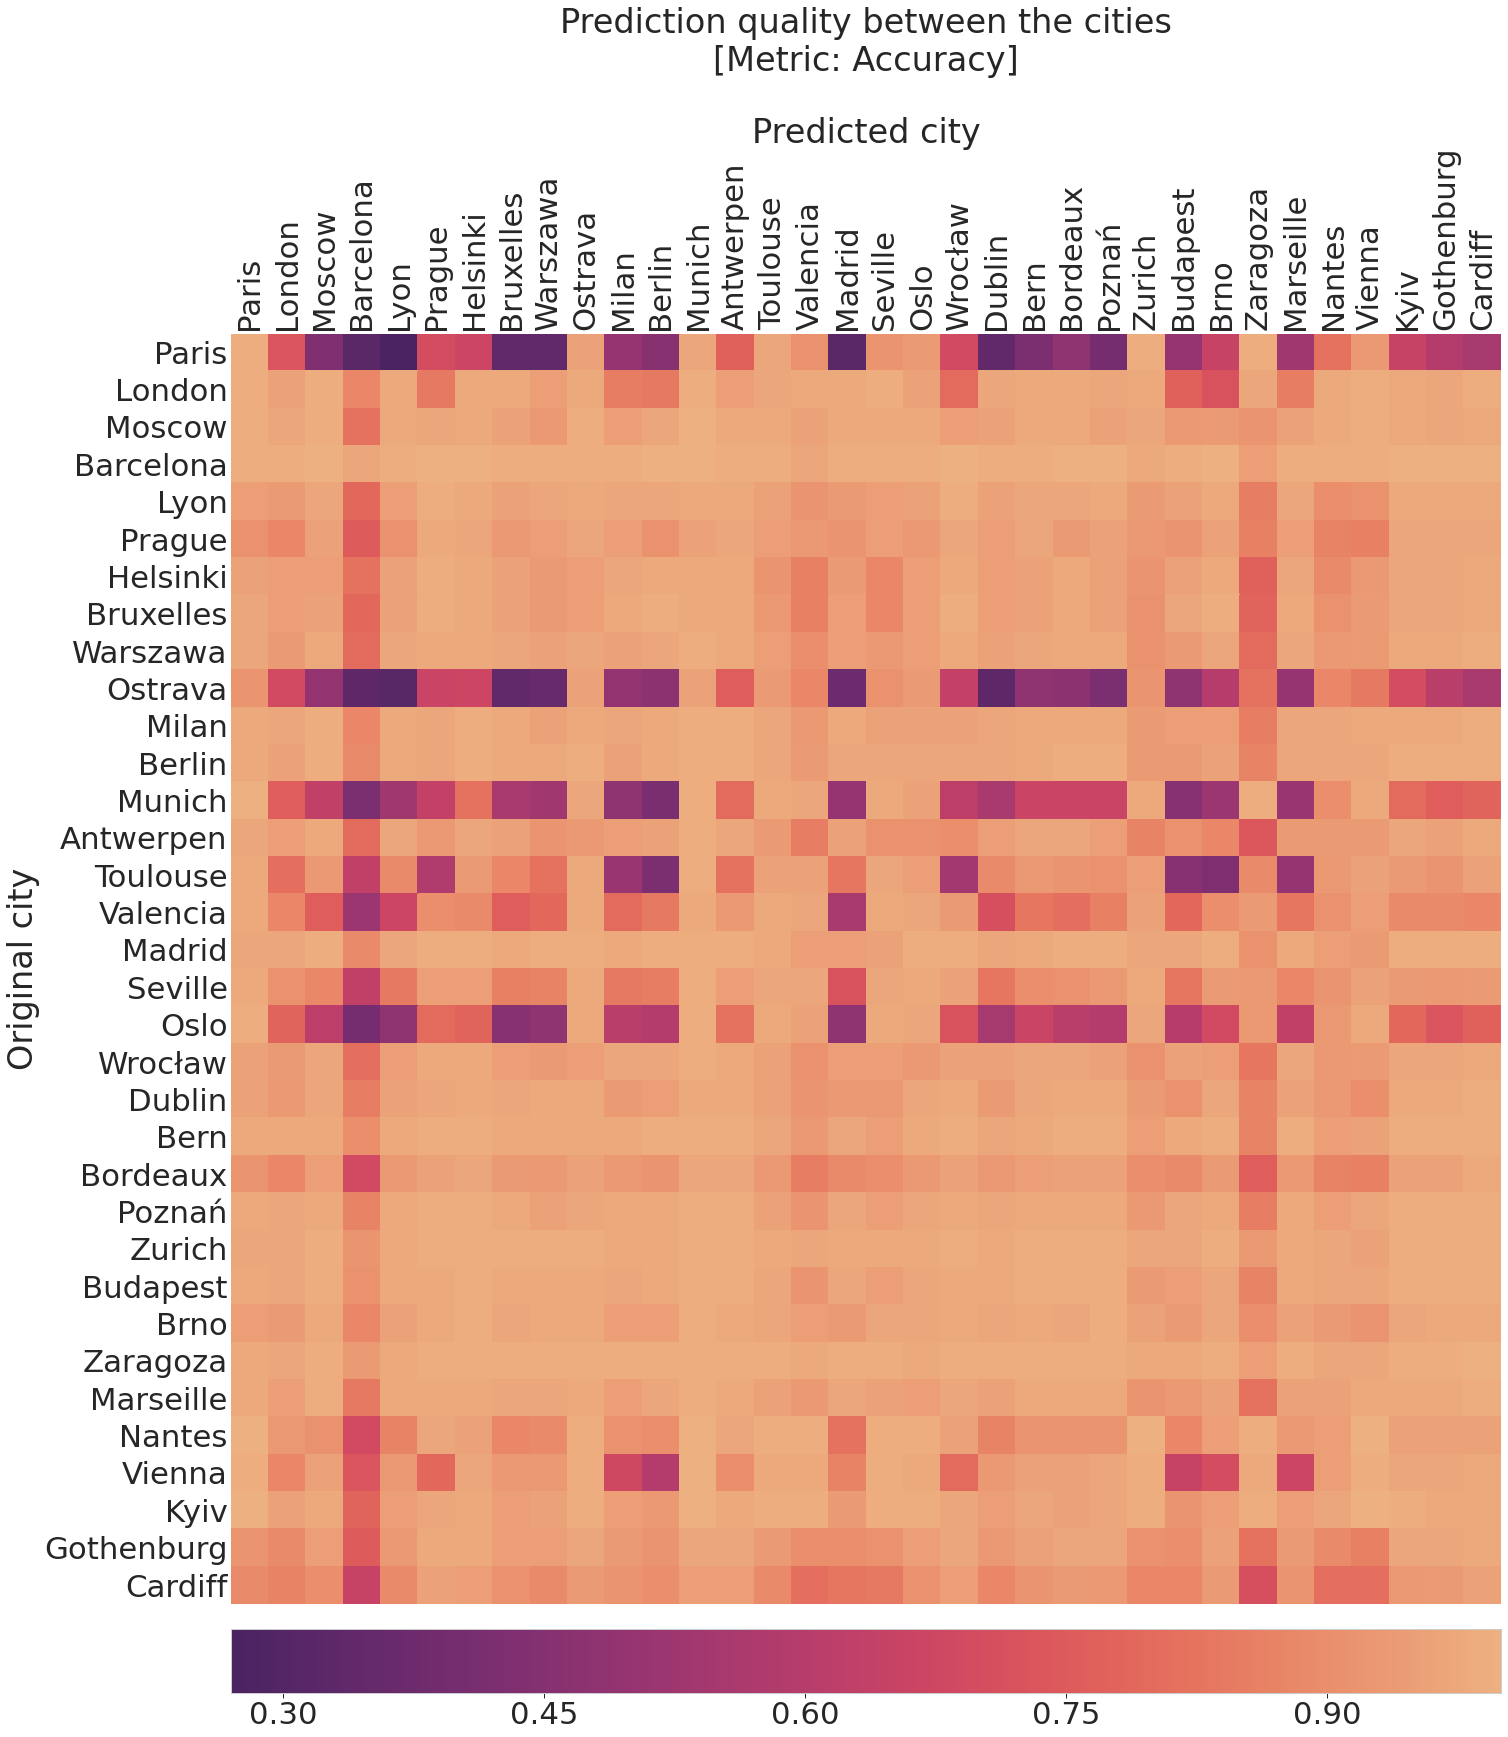

In [17]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

# grid_kws = {"height_ratios": (1, .05), "hspace": .3}
# fig, (ax, cbar_ax) = plt.subplots(2, figsize=(10,15), gridspec_kw=grid_kws)

fig = plt.figure(figsize=(25,25))
ax = sns.heatmap(
    data=grpd.round(2),
    square=True,
    # annot=True,
    # ax=ax,
    cmap="flare_r",
    cbar=False
    # cbar_ax=cbar_ax,
    # cbar_kws={"orientation": "horizontal"},
    # cbar_kws = dict(use_gridspec=False,location="bottom")
)

ax.set_title(f"Prediction quality between the cities\n[Metric: Accuracy]\n")

ax.set_xlabel("Predicted city")
ax.set_ylabel("Original city")

# ax.xaxis.set_ticks_position('top')
# xticks(range(5), rotation=90, size='xx-large') 
ax.xaxis.set_label_position('top')
ax.tick_params(axis=u'both', which=u'both',length=0)

ax_divider = make_axes_locatable(ax)
# define size and padding of axes for colorbar
cax = ax_divider.append_axes('bottom', size = '5%', pad = '2%')
# make colorbar for heatmap. 
# Heatmap returns an axes obj but you need to get a mappable obj (get_children)
colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal')
# locate colorbar ticks
cax.xaxis.set_ticks_position('bottom')

ax.set_yticklabels(stat_ord, rotation = 0)
ax.set_xticklabels(stat_ord, rotation = 90)

# fig.subplots_adjust(wspace=0.1, hspace=0.55)
# fig.subplots_adjust(top=0.96) # adjust the Figure in rp
# fig.suptitle(f'Prediction quality between the cities\n[Metric: Balanced accuracy]')

# g.set_axis_labels(, )

plt.savefig(f'transfer_learning_stations_accuracy.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.savefig(f'transfer_learning_stations_accuracy.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [ ]:
for metric in ['accuracy', 'custom_metric', 'f1_score', 'balanced_accuracy', 'precision', 'recall']:
    filtered_df = df_flat.loc[df_flat.metric_raw == metric]
    grpd = filtered_df[['city_from', 'city_to', 'value']].groupby(['city_from', 'city_to']).mean().reset_index()
    grpd = grpd.pivot(index=['city_from'], columns=['city_to'], values='value')
    print(metric)
    print(grpd.round(3))

<ipython-input-21-8d6a64aaeecb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ResNeigh'] = filtered_df.apply(lambda x: f"Resolution: {x['resolution']}\nNeighbourhood size: {x['neighbours']}", axis=1)
Accuracy
Accuracy
Accuracy
Balanced accuracy
Balanced accuracy
Balanced accuracy
Custom metric
Custom metric
Custom metric
F1 Score
F1 Score
F1 Score
Precision
Precision
Precision
Recall
Recall
Recall


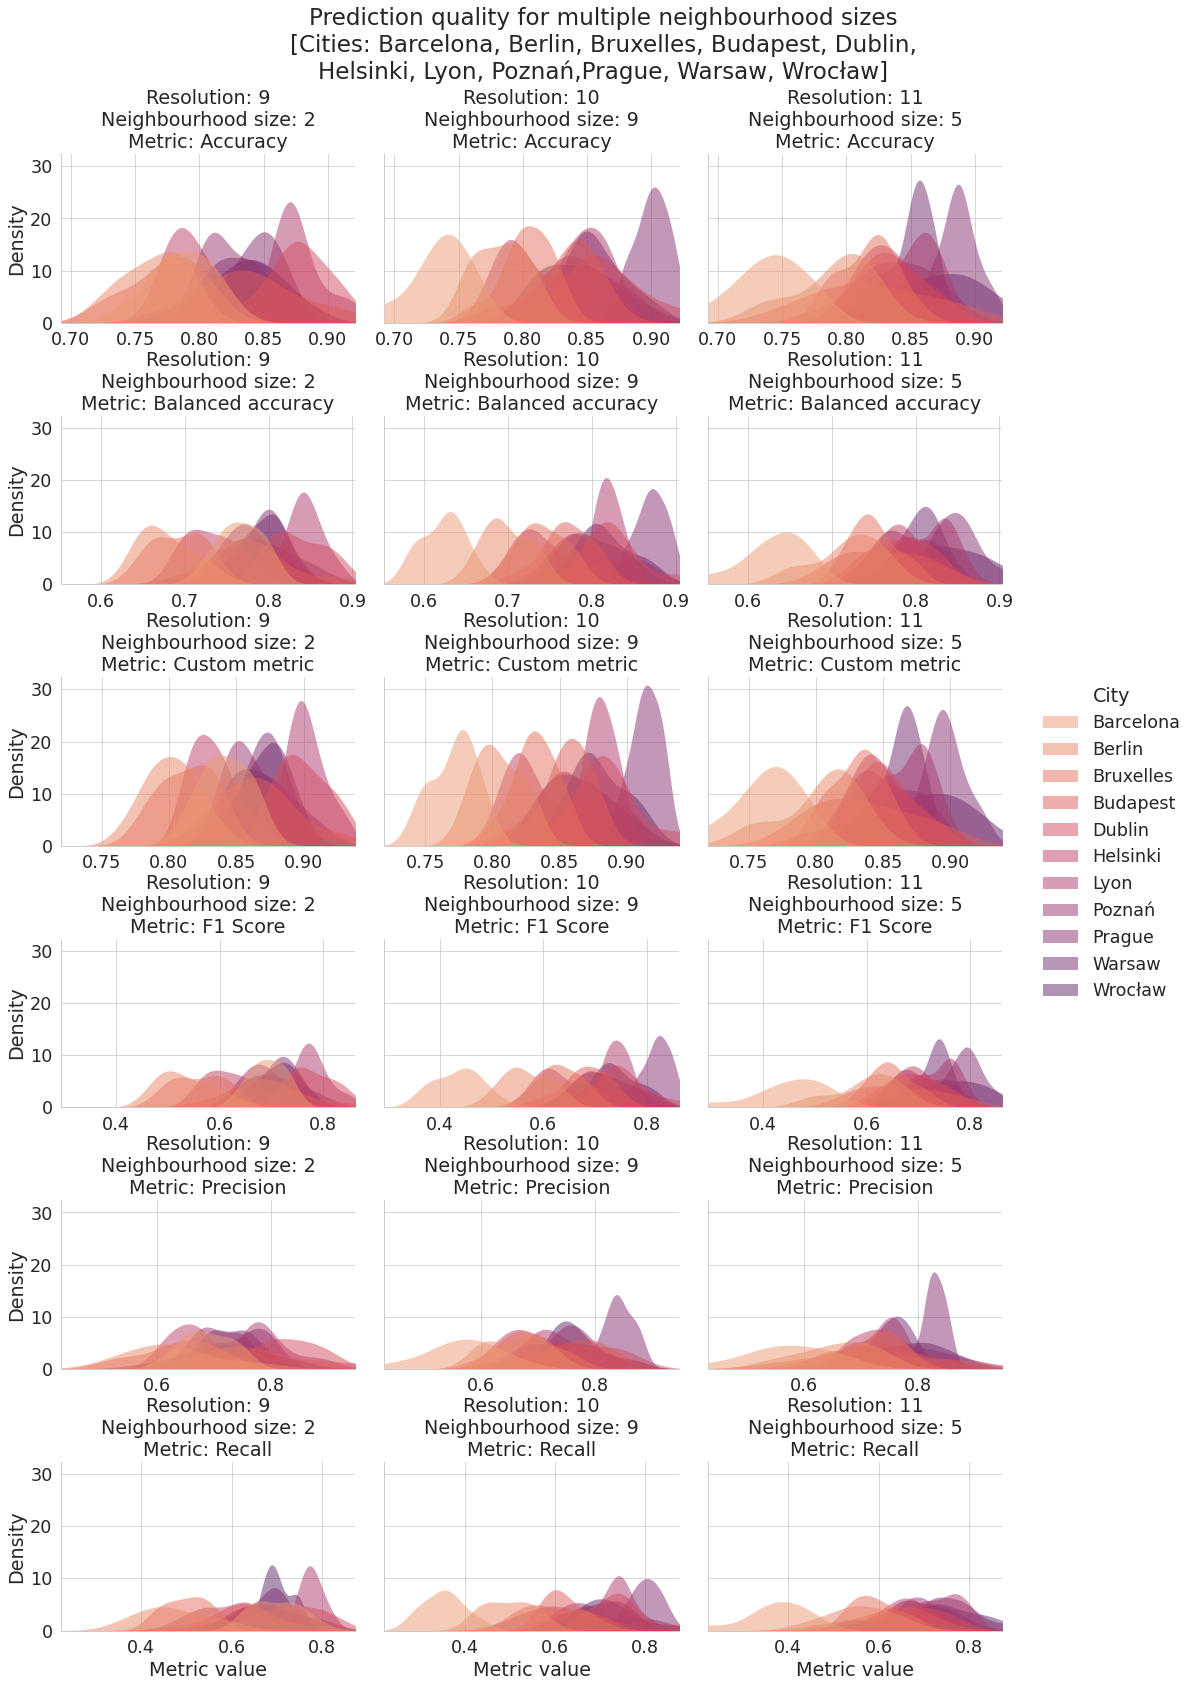

In [21]:
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 4})
filtered_df = df_flat.loc[
    # (df_flat.city == 'Wrocław') \
    # (df_flat.resolution == res) \
    # (df_flat.resolution == res) \
    (((df_flat.resolution == 9) & (df_flat.neighbours == 2)) | ((df_flat.resolution == 10) & (df_flat.neighbours == 9)) | ((df_flat.resolution == 11) & (df_flat.neighbours == 5)))
    # & (df_flat.dataset_type == 'test') \
    & (df_flat.dataset_type == 'validation') \
    # & ((df_flat.classfier_cls == 'RandomForestClassifier') \
    # | (df_flat.classfier_cls == 'BalancedRandomForestClassifier') \
    # | (df_flat.classfier_cls =='BalancedSubsampleRandomForestClassifier')) \
    # & (df_flat.neighbours > 0) \
    # & (df_flat.inbalance_ratio == 1) \
    # & (df_flat.classfier_cls == 'RandomForestClassifier')
]
filtered_df['ResNeigh'] = filtered_df.apply(lambda x: f"Resolution: {x['resolution']}\nNeighbourhood size: {x['neighbours']}", axis=1)
g = sns.displot(
    data=filtered_df,
    # x="embedding_cls",
    x="value",
    # multiple="stack",
    # x="emb_cls",
    # x=a,
    # order="embedding_cls",
    # y="value",
    # y="inbalance_ratio_str",
    # y="embedding_cls",
    # hue="neighbours",
    # hue="classfier_cls",
    hue="city",
    # size="neighbours",
    # linewidth=0,
    # hue="classfier_cls",
    # size="choice",
    # col="align",
    # kind="point",
    kind="kde",
    # dodge=True,
    # capsize=.1,
    # kind="violin",
    # kind="scatter",
    # row="metric",
    col="ResNeigh",
    row="metric",
    # size_order=["T1", "T2"],
    # palette=palette,
    palette="flare",
    # palette="Set1",
    height=4,
    aspect=1.2,
    # sharex=True,
    # sharey=False,
    alpha=.5,
    common_norm=False, 
    fill=True, 
    linewidth=0,
    facet_kws=dict(sharex=False, sharey=True),
    # alpha=0.5
    # orient="h"
)

# # # # # iterate over axes of FacetGrid
# for (ax, metric) in zip(g.axes.flat, list(filtered_df.metric.unique()) * 3):
#     print(ax, metric)
#     # metrics_df = filtered_df.loc[filtered_df.metric == metric]
#     # sns.distplot(ax=ax, data=metrics_df, x='neighbours', y='value', err_style="bars", color="k", ls='--', legend=None, label='Mean')
#     # # labels = ax.get_xticklabels() # get x labels
#     # # for i,l in enumerate(labels):
#     # #     if(i%2 == 0): labels[i] = '' # skip even labels
#     # ax.set(xticks=list(filtered_df.neighbours.unique()))

#     # ax.set_yticklabels(list(embedding_clf_dict_rev.values())) # set new labels
#     pass

# ax2.plot(a, y) #we plot y as a function of a, which parametrizes x
# g. set_ticks(a) #set the ticks to be a
# g.set_ticklabels(filtered_df['emb_cls']) # change the ticks' names to x

# g.set(xticks=a, xticklabels=filtered_df['emb_cls'])
# plt.ylim(0, 1)

g.map(set_scale, 'metric', color='k', alpha=0.5)
g.set_axis_labels("Metric value", "Density")
# g.map(mean_line, res color='k', ls='--')
# g.set_axis_labels("Neighbourhood size", "Metric value")
# g.set_axis_labels("Metric value", "Imbalance ratio")
# g.set_titles("Metric: {row_name}")
# g.set_titles("Resolution: {row_name}\nMetric:\n{row_name}")
g.set_titles("{col_name}\nMetric: {row_name}")

g.fig.subplots_adjust(wspace=0.1, hspace=0.55)
g.fig.subplots_adjust(top=0.895) # adjust the Figure in rp
g.fig.suptitle(f'Prediction quality for multiple neighbourhood sizes\n[Cities: Barcelona, Berlin, Bruxelles, Budapest, Dublin,\nHelsinki, Lyon, Poznań,Prague, Warsaw, Wrocław]')

# # plt.legend(title='City')
# handles = g._legend.legendHandles
# line = mlines.Line2D([0], [0], label='Mean value', color="k", ls='--')
# handles.append(line)
# g._legend.legendHandles = handles

g._legend.set_title("City")
g._legend.get_title().set_multialignment('center')
# plt.tight_layout()

plt.savefig(f'neighbourhood_size_final_comparison.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [23]:
sns.color_palette("Paired", 11)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6)]

In [26]:
sns.color_palette("Set1", 11)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)]